# MNIST Standard Biological Images: CNN1D Neural Network

In [10]:
import time
from datetime import datetime
import re
import numpy as np
import pandas as pd
#import seaborn as sns  # for nicer plots
#sns.set(style="darkgrid")  # default style
import tensorflow as tf
from tensorflow import keras
from keras import metrics
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, MaxPooling1D, InputLayer
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
tf.get_logger().setLevel('INFO')

# Get date/time for local timezone
def get_localdate_str():
    tm_str = str(datetime.now())
    return tm_str

def get_time_with_minutes(date_str):
    tm_str = re.sub('^....-..-.. ', "", date_str)
    tm_str = re.sub(':..\.......$', "", tm_str)
    tm_str = re.sub(":", "-", tm_str)
    return tm_str

def get_date_with_seconds(date_str):
    tm_str = re.sub('\.......$', "", date_str)
    tm_str = re.sub(" ", "_", date_str)
    return tm_str

In [11]:
def display_confusion_matrix(y_tst, y_prd, ttl=None, sz=5, lbl=None):
    # Generate and display the confusion matrix
    cm = confusion_matrix(y_tst, y_prd)

    # Plot confusion matrix with labels
    fig, ax = plt.subplots(figsize=(sz,sz))
    
    if (lbl != None):
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)

        # Set labels and title
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')

        # Set tick labels
        ax.set_xticks(np.arange(len(lbl)))
        ax.set_yticks(np.arange(len(lbl)))
        ax.set_xticklabels(lbl)
        ax.set_yticklabels(lbl)

        # Rotate x-tick labels
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Add values to cells (optional)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > cm.max() / 2. else "black")
    else:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues, ax=ax)

    # Customize plot
    plt.title(ttl)
    plt.show()

In [12]:
def get_data_set_dimensions(contained_array, data):
    x_shape = data.shape
    end_of_range = len(x_shape)
    #print("end_of_range:", end_of_range)

    dim = ""
    if end_of_range == 4:
        if x_shape[3] == 3:
            dim = "RGB images:"
        else:
            dim = "3D images: "
        dim = dim + str(x_shape[1]) + "x" + str(x_shape[2]) + "x" + str(x_shape[3])
    elif end_of_range == 3:
        dim = "2D images: " + str(x_shape[1]) + "x" + str(x_shape[2])
    if (dim != ""):
        print(f"  {contained_array}: {x_shape[0]} {dim}")

    return end_of_range

In [13]:
def flatten_data(contained_array, data, end_of_range):
    data_shape = data.shape
    
    if (end_of_range > 2):
        # Handle 2D, 3D, ... nD image dimensions
        flat_sz = 1
        for ix in range(1, end_of_range):
            flat_sz = flat_sz * data_shape[ix]
        #print("flat_sz:", flat_sz)
        data = data.reshape(-1, flat_sz)
    else:
        # Convert label dimensions to 1D
        data = np.ravel(data, order='C')
    return(data)

## Load data then flatten labels, images are flattened later within LR model

In [14]:
def load_and_flatten(fn):
    npz_file = np.load(fn, allow_pickle=True)
    #print(fn, "arrays:", blood_npz.files)

    # Dictionaries to store flattened image data
    flat_arr = {}
    label_arr = {}
    # Dictionary to store images (unflattened)
    orig_arr = {}
    
    substr = "labels"

    for contained_array in npz_file.files:
        # Only labels need to be flattened.
        # Features (images) will be flattened by the Logistic Regression model
        end_of_range = get_data_set_dimensions(contained_array, npz_file[contained_array])
        match = re.search(substr, contained_array)
        if (match):
            #print(f"  BEFORE: {contained_array}: {npz_file[contained_array].shape}")
            arr = flatten_data(contained_array, npz_file[contained_array], end_of_range)
            label_arr[contained_array] = arr
            #print(f"  {contained_array} (flattened): {label_arr[contained_array].shape}")
        else:
            orig_arr[contained_array] = npz_file[contained_array]
    
    return orig_arr, label_arr

## Build a Keras Logistic Regression model using a single Dense layer

In [15]:
def build_model(n_classes,
                img_dim,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='adam',
                learning_rate=0.01):

    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # Keras logistic regression has input and output layers with as a single Dense layer.
    # So hidden_layer will be 0 for this model

    hidden_layers = len(hidden_layer_sizes)
    ix = 0

    model = keras.Sequential()
    model.add(keras.Input(shape=img_dim))
    model.add(Conv1D(32, 3, activation="relu"))
    model.add(MaxPooling1D())
    model.add(Flatten())
    while(hidden_layers != 0):
        model.add(Dense(hidden_layer_sizes[ix], activation=activation))
        ix += 1
        hidden_layers -= 1
    model.add(Dense(n_classes, activation='softmax')) # Output layer with n-classes
    # Display the model summary to see the architecture
    model.summary()
    
    # Compile the model using the Adam optimizer
    #model.compile(optimizer='adam',
    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                #loss='categorical_crossentropy',
                metrics=['accuracy'],
            )
    return model

In [16]:
def process_file(fn):

    #result_dict = {}
    csv_data = [[]]
    print("\n-------------------------------------------------------")
    print(fn)
    original_imgs, labels = load_and_flatten(fn)
    feature_keys = list(original_imgs.keys())
    #print(feature_keys)
    label_keys = list(labels.keys())
    #print(label_keys)
    
    img_shape = original_imgs[feature_keys[0]].shape
    img_dim = []
    for ix in range(1, len(img_shape)):
        img_dim.append(img_shape[ix])
    #print("img_dim:", img_dim)

    X_train = original_imgs[feature_keys[0]]
    y_train = labels[label_keys[0]]
    X_test = original_imgs[feature_keys[2]]
    y_test = labels[label_keys[2]]

    # Find number of unique classes within data set
    class_cnt, value_cnts = np.unique(labels[label_keys[0]], return_counts=True)
    #print(f"class_cnt: {class_cnt}")
    #print(f"value_cnts: {value_cnts}")
    n_classes = len(class_cnt)
    #print(f"n_classes: {n_classes}")

    # Display the first image and label in the training data
    print("\nLabel: ", y_train[0])
    if len(img_dim) < 3 or img_dim[2] == 3:
        #img_arr = original_imgs[feature_keys[0]]
        img = X_train[0]
        plt.imshow(img)
        plt.axis('off')
        plt.show()

    # Build model and train with a variety of learning rates and epochs for each data set
    for learning_rate in [0.1, 0.01, 0.001]:
        
        # Build the Feed Forward Neural Network Model
        #kerasCNN1d = build_model(n_classes, img_dim, [64], 'relu', 'adam', learning_rate)
        
        for num_epochs in [25, 50, 100, 150]:

            # Build the Feed Forward Neural Network Model
            kerasCNN1d = build_model(n_classes, img_dim, [64], 'relu', 'adam', learning_rate)
            
            ttl = fn + ": Epochs " + str(num_epochs) + ", LR " + str(learning_rate)
            # Train the CNN1d model.
            print(f'\nTraining... {ttl}')
            start = time.time()
            history = kerasCNN1d.fit(
                x=X_train,
                y=y_train,
                epochs=num_epochs,
                batch_size=64,
                validation_split=0.1,
                validation_data=(X_test, y_test),
                verbose=0)
            trn_elapsed = time.time() - start

            train_accuracy = history.history['accuracy']
            val_accuracy = history.history['val_accuracy']
            plt.plot(train_accuracy, label='train_accuracy')
            plt.plot(val_accuracy, label='validation accuracy')
            #plt.xticks(range(num_epochs))
            plt.xlabel('Training epochs')
            plt.ylabel('Accuracy')
            plt.title(ttl)
            plt.legend()
            plt.show()

            # Evaluate the model and determine final accuracy
            start = time.time()
            #test_accuracy = kerasCNN1d.evaluate(x=X_test, y=y_test, verbose=0,
            #                             return_dict=True)['accuracy']
            loss, test_accuracy = kerasCNN1d.evaluate(x=X_test, y=y_test, verbose=0)
            eval_elapsed = time.time() - start
        
            print(f"Training time: {round(trn_elapsed, 2)} seconds")
            print(f"Evaluation time: {round(eval_elapsed, 2)} seconds")
            print(f"Accuracy: {round(test_accuracy * 100, 3)}, Loss: {round(loss, 5)}, Epochs: {num_epochs}, LR {learning_rate}")
            #run_result = { 'lr' : learning_rate, 'ep' : num_epochs, 'acc' : test_accuracy, 'loss' : loss, \
            #                       'ttime' : trn_elapsed }
            #result_dict[ttl] = run_result
            csv_row = np.array([fn, learning_rate, num_epochs, round(test_accuracy * 100, 2), \
                                round(loss, 5), round(trn_elapsed, 2)])
            csv_data.append(csv_row)

            %reset_selective -f history.history['accuracy'], history.history['val_accuracy']

            #print(result_dict)
            
    return csv_data


-------------------------------------------------------
breastmnist.npz
  train_images: 546 2D images: 28x28
  val_images: 78 2D images: 28x28
  test_images: 156 2D images: 28x28

Label:  1


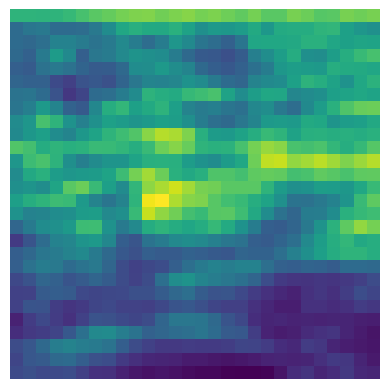

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,538 (115.38 KB)

 Trainable params: 29,538 (115.38 KB)

 Non-trainable params: 0 (0.00 B)


Training... breastmnist.npz: Epochs 25, LR 0.1


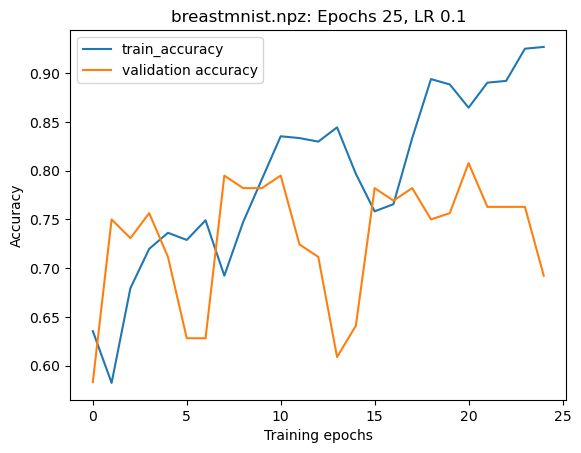

Training time: 1.82 seconds
Evaluation time: 0.08 seconds
Accuracy: 69.231, Loss: 2.73548, Epochs: 25, LR 0.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,538 (115.38 KB)

 Trainable params: 29,538 (115.38 KB)

 Non-trainable params: 0 (0.00 B)


Training... breastmnist.npz: Epochs 50, LR 0.1


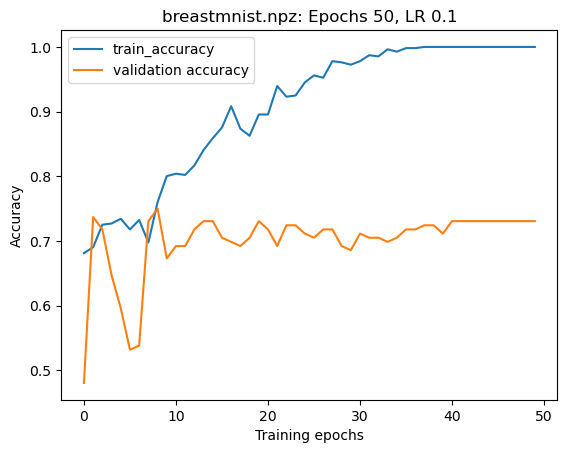

Training time: 3.1 seconds
Evaluation time: 0.04 seconds
Accuracy: 73.077, Loss: 2.775, Epochs: 50, LR 0.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,538 (115.38 KB)

 Trainable params: 29,538 (115.38 KB)

 Non-trainable params: 0 (0.00 B)


Training... breastmnist.npz: Epochs 100, LR 0.1


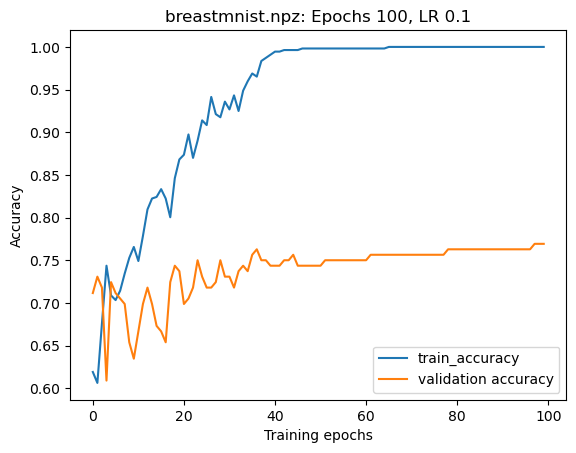

Training time: 5.79 seconds
Evaluation time: 0.04 seconds
Accuracy: 76.923, Loss: 2.54366, Epochs: 100, LR 0.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,538 (115.38 KB)

 Trainable params: 29,538 (115.38 KB)

 Non-trainable params: 0 (0.00 B)


Training... breastmnist.npz: Epochs 150, LR 0.1


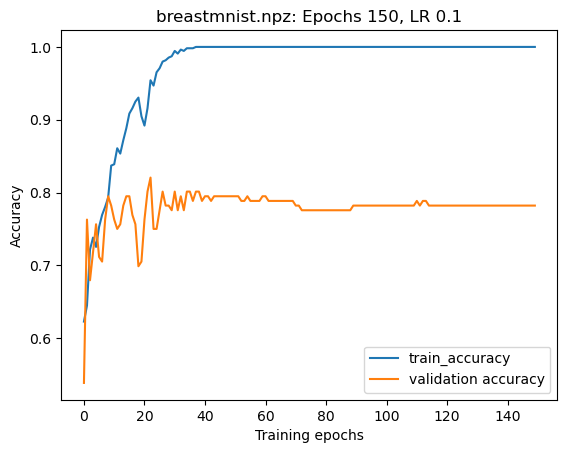

Training time: 8.31 seconds
Evaluation time: 0.04 seconds
Accuracy: 78.205, Loss: 1.64599, Epochs: 150, LR 0.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,538 (115.38 KB)

 Trainable params: 29,538 (115.38 KB)

 Non-trainable params: 0 (0.00 B)


Training... breastmnist.npz: Epochs 25, LR 0.01


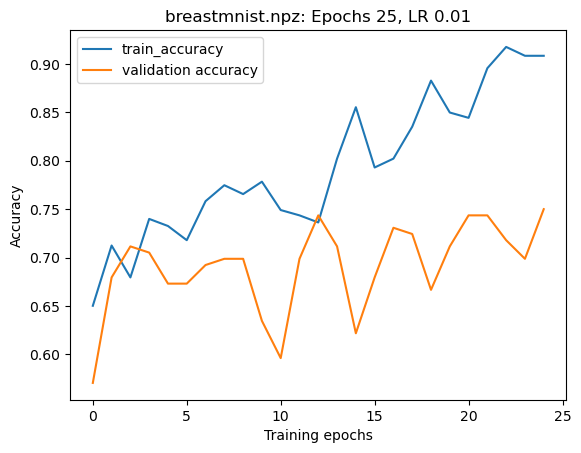

Training time: 1.81 seconds
Evaluation time: 0.09 seconds
Accuracy: 75.0, Loss: 2.8025, Epochs: 25, LR 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,538 (115.38 KB)

 Trainable params: 29,538 (115.38 KB)

 Non-trainable params: 0 (0.00 B)


Training... breastmnist.npz: Epochs 50, LR 0.01


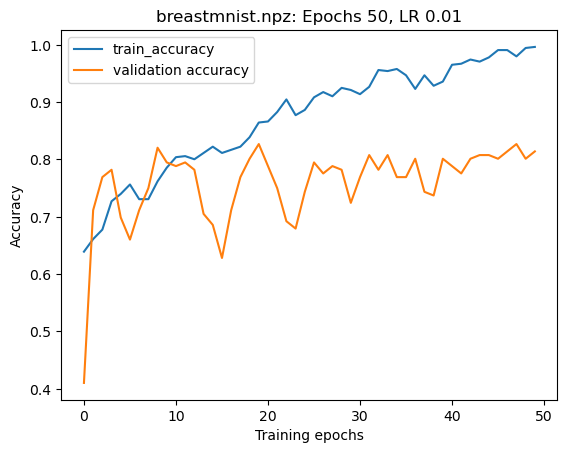

Training time: 3.13 seconds
Evaluation time: 0.04 seconds
Accuracy: 81.41, Loss: 1.26219, Epochs: 50, LR 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,538 (115.38 KB)

 Trainable params: 29,538 (115.38 KB)

 Non-trainable params: 0 (0.00 B)


Training... breastmnist.npz: Epochs 100, LR 0.01


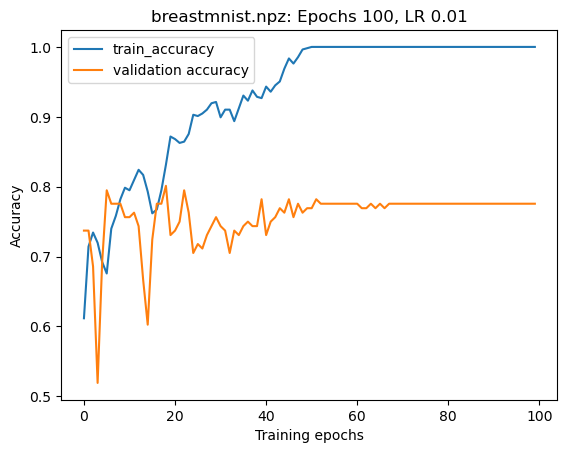

Training time: 5.72 seconds
Evaluation time: 0.04 seconds
Accuracy: 77.564, Loss: 2.41877, Epochs: 100, LR 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,538 (115.38 KB)

 Trainable params: 29,538 (115.38 KB)

 Non-trainable params: 0 (0.00 B)


Training... breastmnist.npz: Epochs 150, LR 0.01


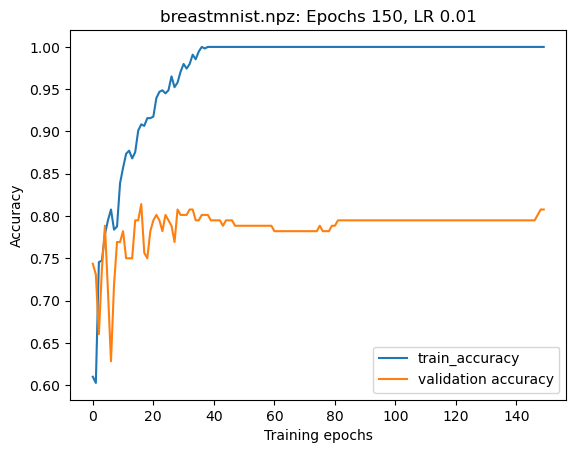

Training time: 8.31 seconds
Evaluation time: 0.04 seconds
Accuracy: 80.769, Loss: 1.46482, Epochs: 150, LR 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,538 (115.38 KB)

 Trainable params: 29,538 (115.38 KB)

 Non-trainable params: 0 (0.00 B)


Training... breastmnist.npz: Epochs 25, LR 0.001


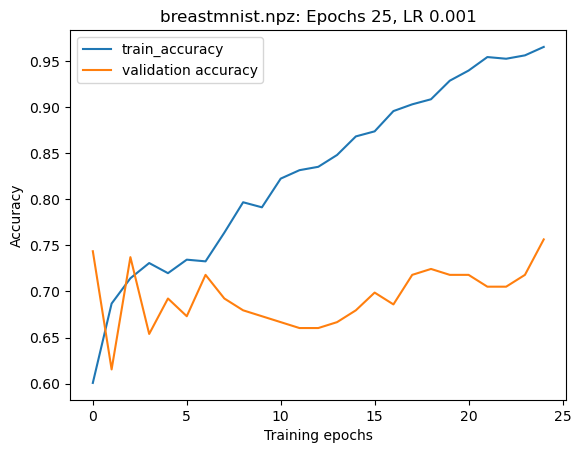

Training time: 1.83 seconds
Evaluation time: 0.04 seconds
Accuracy: 75.641, Loss: 1.59492, Epochs: 25, LR 0.001


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,538 (115.38 KB)

 Trainable params: 29,538 (115.38 KB)

 Non-trainable params: 0 (0.00 B)


Training... breastmnist.npz: Epochs 50, LR 0.001


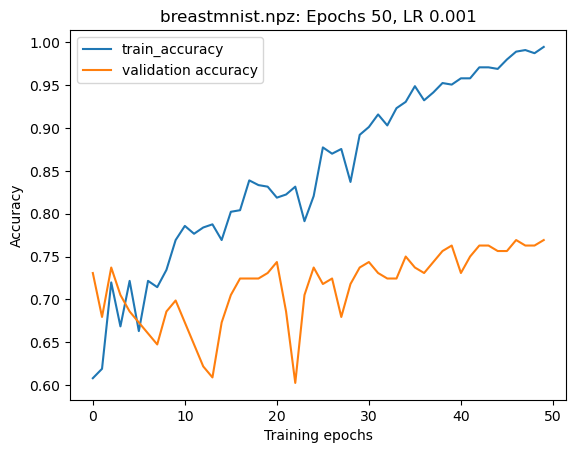

Training time: 3.12 seconds
Evaluation time: 0.04 seconds
Accuracy: 76.923, Loss: 2.33289, Epochs: 50, LR 0.001


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,538 (115.38 KB)

 Trainable params: 29,538 (115.38 KB)

 Non-trainable params: 0 (0.00 B)


Training... breastmnist.npz: Epochs 100, LR 0.001


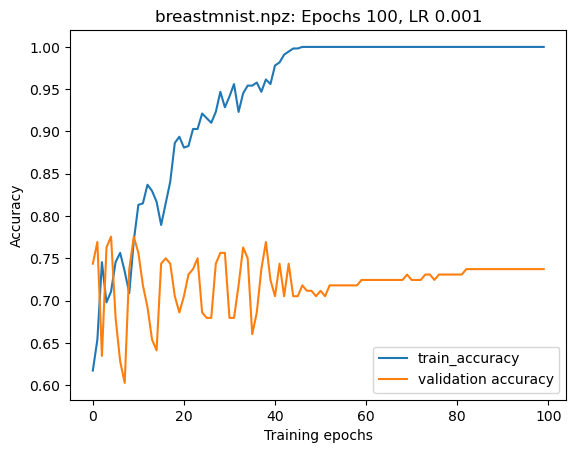

Training time: 5.69 seconds
Evaluation time: 0.04 seconds
Accuracy: 73.718, Loss: 3.39159, Epochs: 100, LR 0.001


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,538 (115.38 KB)

 Trainable params: 29,538 (115.38 KB)

 Non-trainable params: 0 (0.00 B)


Training... breastmnist.npz: Epochs 150, LR 0.001


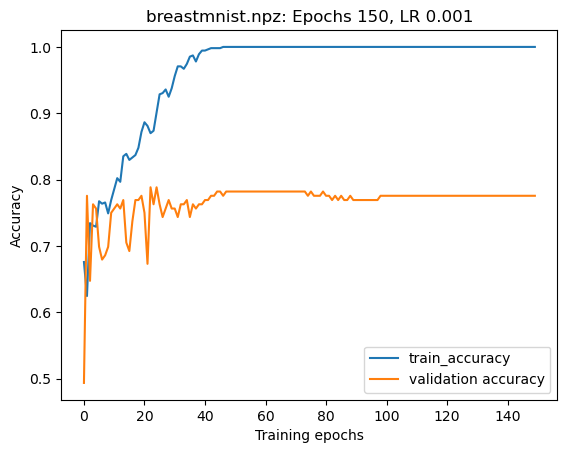

Training time: 8.27 seconds
Evaluation time: 0.04 seconds
Accuracy: 77.564, Loss: 1.98061, Epochs: 150, LR 0.001

-------------------------------------------------------
octmnist.npz
  train_images: 97477 2D images: 28x28
  val_images: 10832 2D images: 28x28
  test_images: 1000 2D images: 28x28

Label:  0


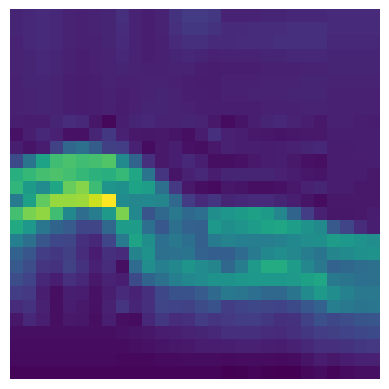

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,668 (115.89 KB)

 Trainable params: 29,668 (115.89 KB)

 Non-trainable params: 0 (0.00 B)


Training... octmnist.npz: Epochs 25, LR 0.1


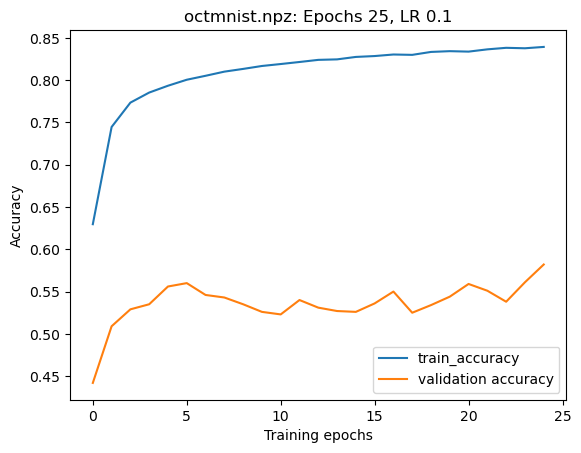

Training time: 39.31 seconds
Evaluation time: 0.06 seconds
Accuracy: 58.2, Loss: 1.12857, Epochs: 25, LR 0.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,668 (115.89 KB)

 Trainable params: 29,668 (115.89 KB)

 Non-trainable params: 0 (0.00 B)


Training... octmnist.npz: Epochs 50, LR 0.1


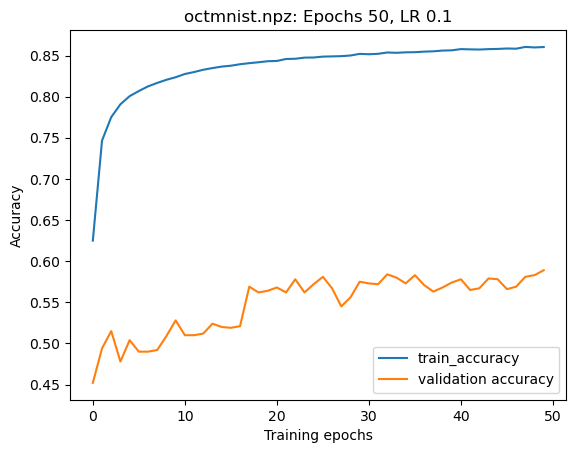

Training time: 77.23 seconds
Evaluation time: 0.06 seconds
Accuracy: 58.9, Loss: 1.40129, Epochs: 50, LR 0.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,668 (115.89 KB)

 Trainable params: 29,668 (115.89 KB)

 Non-trainable params: 0 (0.00 B)


Training... octmnist.npz: Epochs 100, LR 0.1


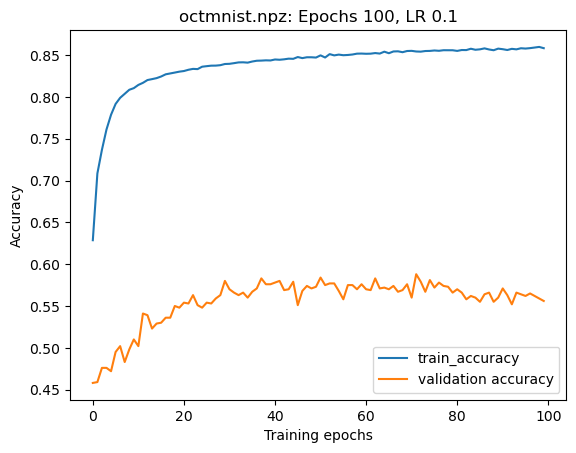

Training time: 155.14 seconds
Evaluation time: 0.06 seconds
Accuracy: 55.6, Loss: 1.52413, Epochs: 100, LR 0.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,668 (115.89 KB)

 Trainable params: 29,668 (115.89 KB)

 Non-trainable params: 0 (0.00 B)


Training... octmnist.npz: Epochs 150, LR 0.1


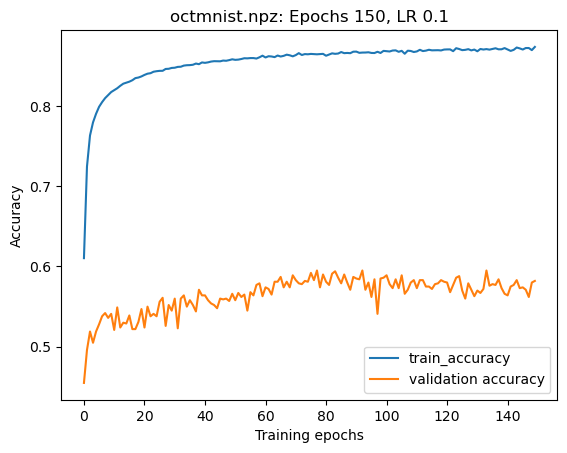

Training time: 231.46 seconds
Evaluation time: 0.06 seconds
Accuracy: 58.2, Loss: 2.23883, Epochs: 150, LR 0.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,668 (115.89 KB)

 Trainable params: 29,668 (115.89 KB)

 Non-trainable params: 0 (0.00 B)


Training... octmnist.npz: Epochs 25, LR 0.01


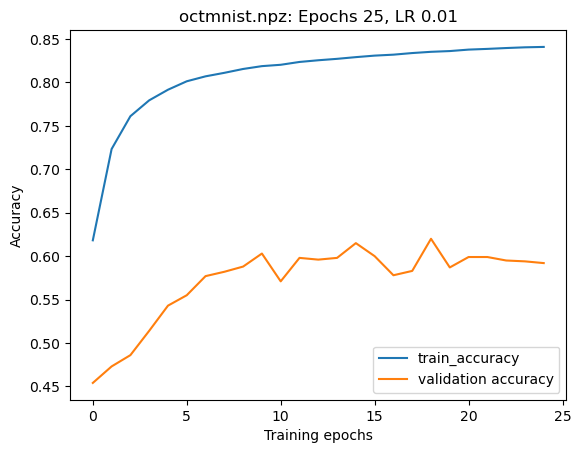

Training time: 38.76 seconds
Evaluation time: 0.06 seconds
Accuracy: 59.2, Loss: 1.10633, Epochs: 25, LR 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,668 (115.89 KB)

 Trainable params: 29,668 (115.89 KB)

 Non-trainable params: 0 (0.00 B)


Training... octmnist.npz: Epochs 50, LR 0.01


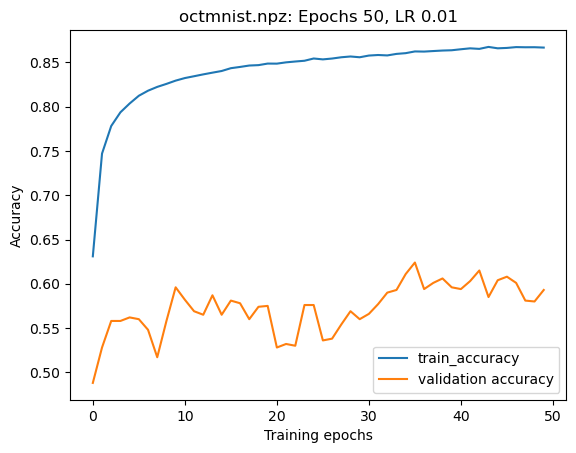

Training time: 77.13 seconds
Evaluation time: 0.06 seconds
Accuracy: 59.3, Loss: 1.38585, Epochs: 50, LR 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,668 (115.89 KB)

 Trainable params: 29,668 (115.89 KB)

 Non-trainable params: 0 (0.00 B)


Training... octmnist.npz: Epochs 100, LR 0.01


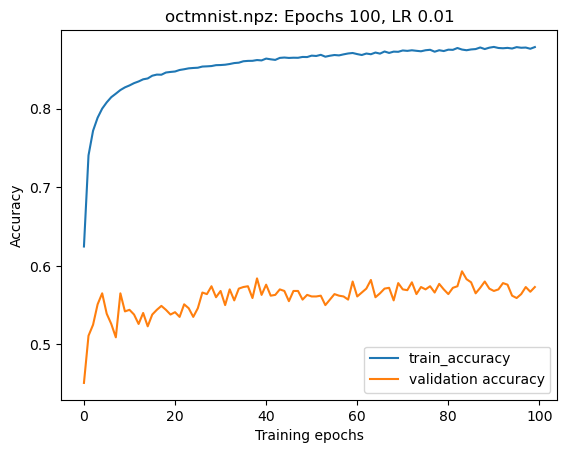

Training time: 154.92 seconds
Evaluation time: 0.06 seconds
Accuracy: 57.3, Loss: 2.1507, Epochs: 100, LR 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,668 (115.89 KB)

 Trainable params: 29,668 (115.89 KB)

 Non-trainable params: 0 (0.00 B)


Training... octmnist.npz: Epochs 150, LR 0.01


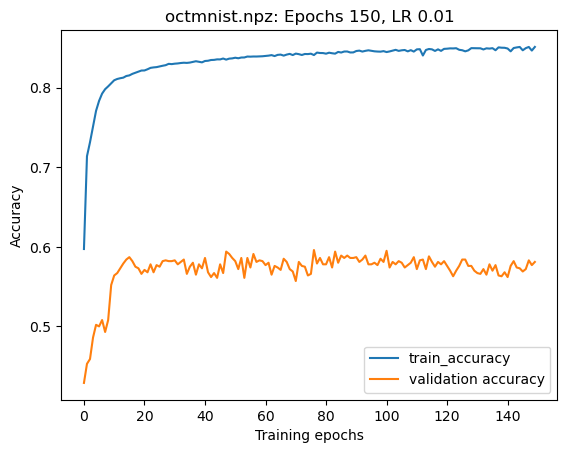

Training time: 233.99 seconds
Evaluation time: 0.09 seconds
Accuracy: 58.1, Loss: 1.80982, Epochs: 150, LR 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,668 (115.89 KB)

 Trainable params: 29,668 (115.89 KB)

 Non-trainable params: 0 (0.00 B)


Training... octmnist.npz: Epochs 25, LR 0.001


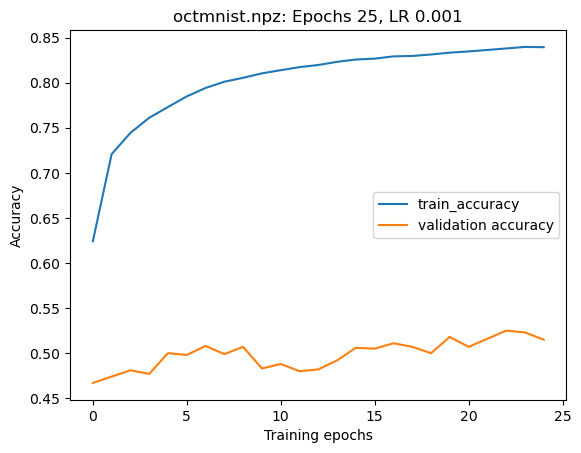

Training time: 38.91 seconds
Evaluation time: 0.06 seconds
Accuracy: 51.5, Loss: 1.45729, Epochs: 25, LR 0.001


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,668 (115.89 KB)

 Trainable params: 29,668 (115.89 KB)

 Non-trainable params: 0 (0.00 B)


Training... octmnist.npz: Epochs 50, LR 0.001


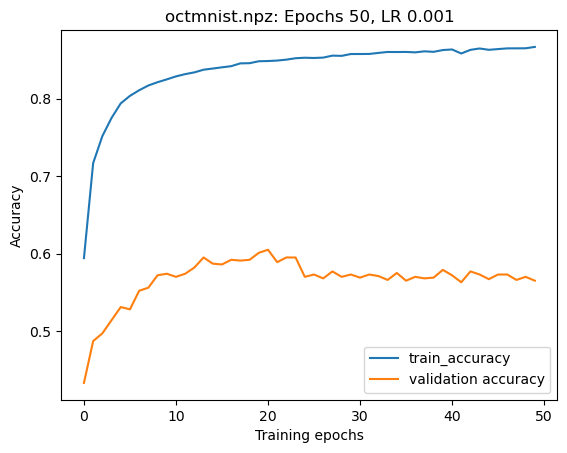

Training time: 78.56 seconds
Evaluation time: 0.06 seconds
Accuracy: 56.5, Loss: 1.48089, Epochs: 50, LR 0.001


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,668 (115.89 KB)

 Trainable params: 29,668 (115.89 KB)

 Non-trainable params: 0 (0.00 B)


Training... octmnist.npz: Epochs 100, LR 0.001


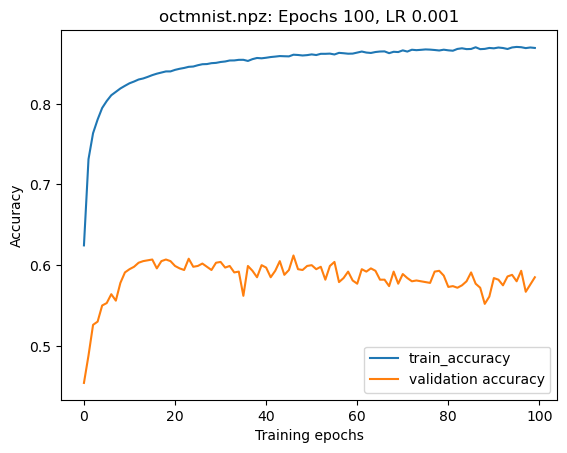

Training time: 153.77 seconds
Evaluation time: 0.06 seconds
Accuracy: 58.5, Loss: 1.49959, Epochs: 100, LR 0.001


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,668 (115.89 KB)

 Trainable params: 29,668 (115.89 KB)

 Non-trainable params: 0 (0.00 B)


Training... octmnist.npz: Epochs 150, LR 0.001


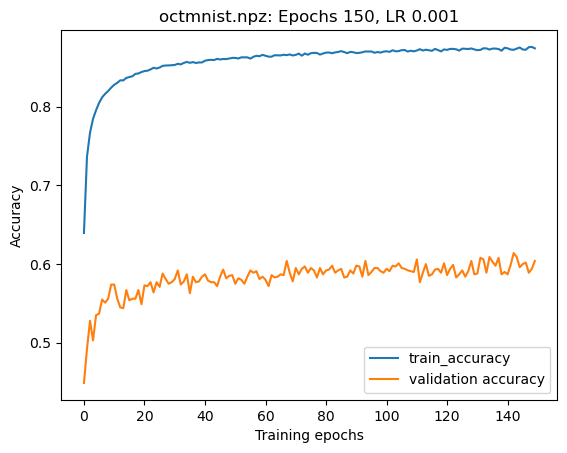

Training time: 235.39 seconds
Evaluation time: 0.06 seconds
Accuracy: 60.4, Loss: 1.77131, Epochs: 150, LR 0.001

-------------------------------------------------------
organsmnist.npz
  train_images: 13932 2D images: 28x28
  val_images: 2452 2D images: 28x28
  test_images: 8827 2D images: 28x28

Label:  8


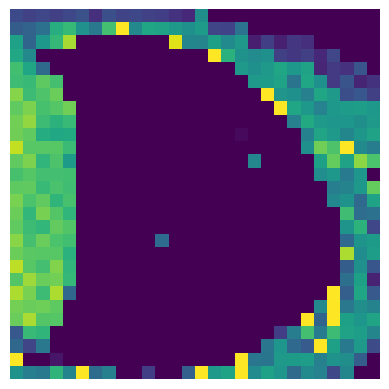

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,123 (117.67 KB)

 Trainable params: 30,123 (117.67 KB)

 Non-trainable params: 0 (0.00 B)


Training... organsmnist.npz: Epochs 25, LR 0.1


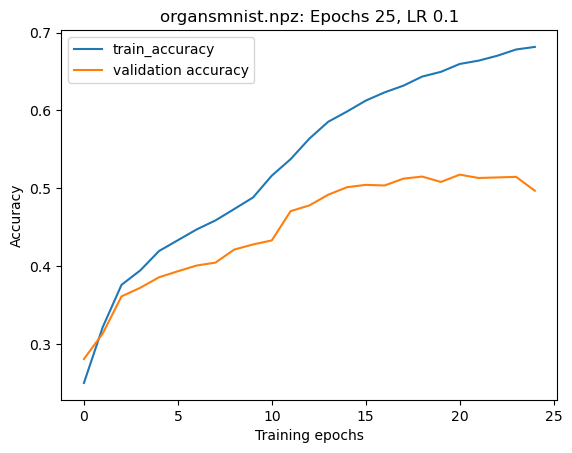

Training time: 9.07 seconds
Evaluation time: 0.21 seconds
Accuracy: 49.677, Loss: 1.84335, Epochs: 25, LR 0.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,123 (117.67 KB)

 Trainable params: 30,123 (117.67 KB)

 Non-trainable params: 0 (0.00 B)


Training... organsmnist.npz: Epochs 50, LR 0.1


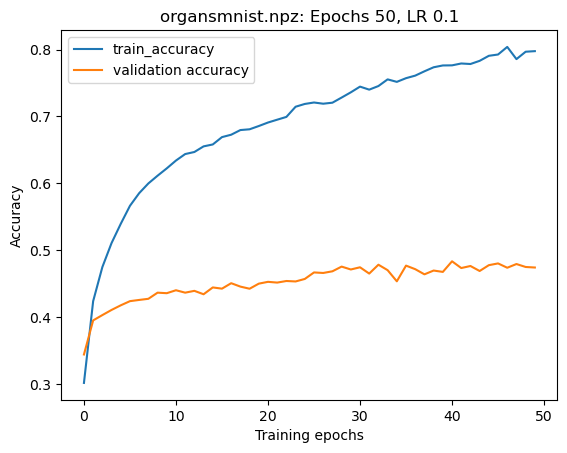

Training time: 17.61 seconds
Evaluation time: 0.27 seconds
Accuracy: 47.411, Loss: 4.51931, Epochs: 50, LR 0.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,123 (117.67 KB)

 Trainable params: 30,123 (117.67 KB)

 Non-trainable params: 0 (0.00 B)


Training... organsmnist.npz: Epochs 100, LR 0.1


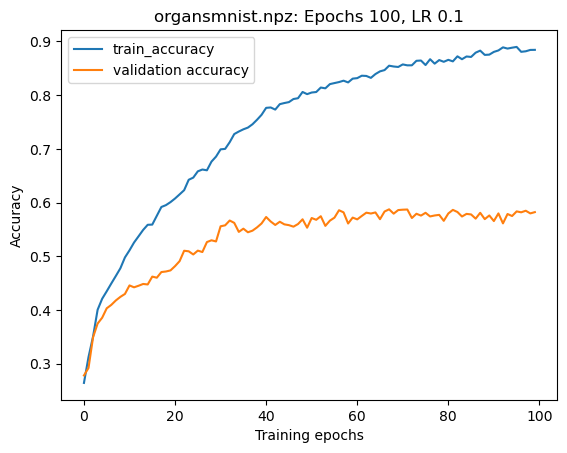

Training time: 34.45 seconds
Evaluation time: 0.21 seconds
Accuracy: 58.208, Loss: 4.41101, Epochs: 100, LR 0.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,123 (117.67 KB)

 Trainable params: 30,123 (117.67 KB)

 Non-trainable params: 0 (0.00 B)


Training... organsmnist.npz: Epochs 150, LR 0.1


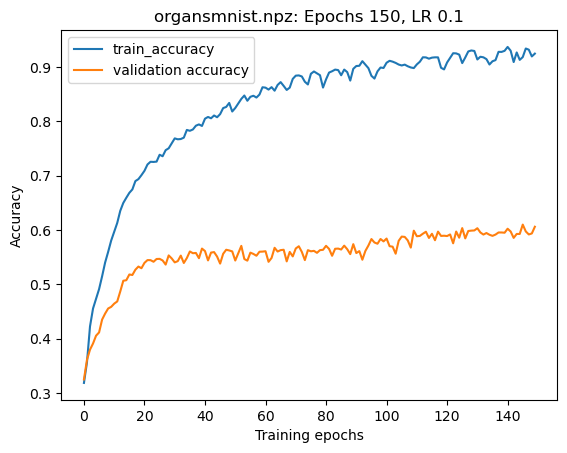

Training time: 51.85 seconds
Evaluation time: 0.21 seconds
Accuracy: 60.587, Loss: 7.63686, Epochs: 150, LR 0.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,123 (117.67 KB)

 Trainable params: 30,123 (117.67 KB)

 Non-trainable params: 0 (0.00 B)


Training... organsmnist.npz: Epochs 25, LR 0.01


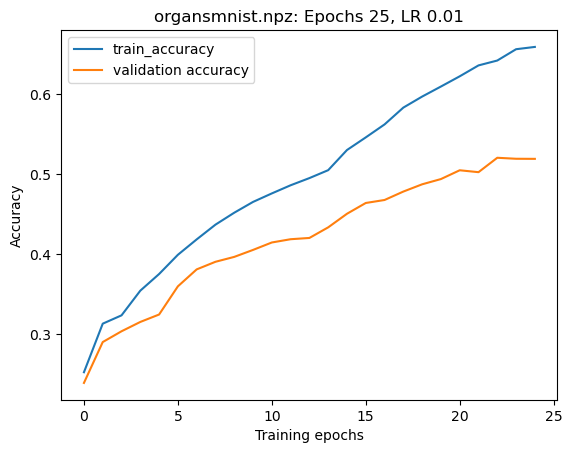

Training time: 9.16 seconds
Evaluation time: 0.21 seconds
Accuracy: 51.932, Loss: 1.81112, Epochs: 25, LR 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,123 (117.67 KB)

 Trainable params: 30,123 (117.67 KB)

 Non-trainable params: 0 (0.00 B)


Training... organsmnist.npz: Epochs 50, LR 0.01


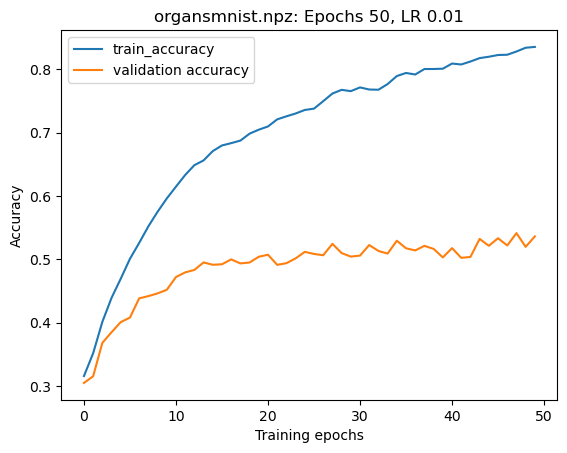

Training time: 18.0 seconds
Evaluation time: 0.23 seconds
Accuracy: 53.608, Loss: 3.74768, Epochs: 50, LR 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,123 (117.67 KB)

 Trainable params: 30,123 (117.67 KB)

 Non-trainable params: 0 (0.00 B)


Training... organsmnist.npz: Epochs 100, LR 0.01


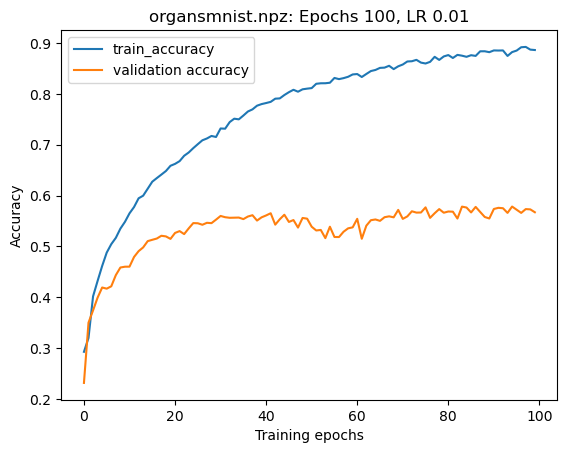

Training time: 35.21 seconds
Evaluation time: 0.21 seconds
Accuracy: 56.724, Loss: 4.90688, Epochs: 100, LR 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,123 (117.67 KB)

 Trainable params: 30,123 (117.67 KB)

 Non-trainable params: 0 (0.00 B)


Training... organsmnist.npz: Epochs 150, LR 0.01


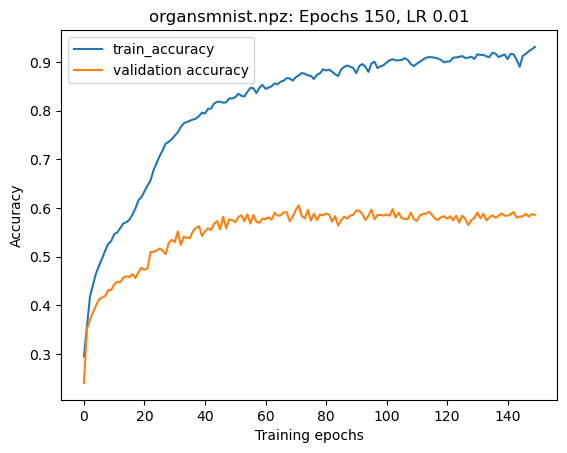

Training time: 52.1 seconds
Evaluation time: 0.2 seconds
Accuracy: 58.582, Loss: 8.96167, Epochs: 150, LR 0.01


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,123 (117.67 KB)

 Trainable params: 30,123 (117.67 KB)

 Non-trainable params: 0 (0.00 B)


Training... organsmnist.npz: Epochs 25, LR 0.001


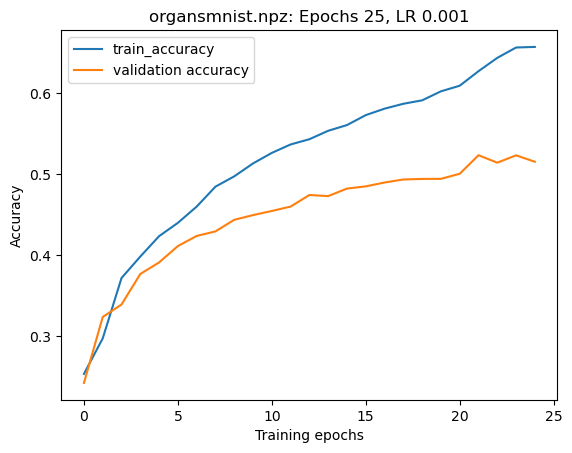

Training time: 9.07 seconds
Evaluation time: 0.2 seconds
Accuracy: 51.512, Loss: 1.79334, Epochs: 25, LR 0.001


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,123 (117.67 KB)

 Trainable params: 30,123 (117.67 KB)

 Non-trainable params: 0 (0.00 B)


Training... organsmnist.npz: Epochs 50, LR 0.001


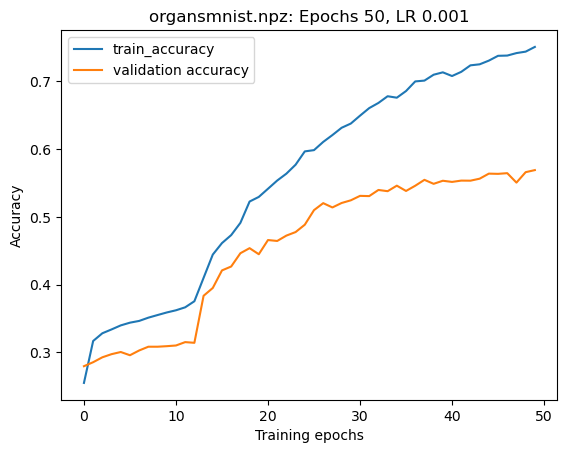

Training time: 17.56 seconds
Evaluation time: 0.2 seconds
Accuracy: 56.905, Loss: 2.04156, Epochs: 50, LR 0.001


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,123 (117.67 KB)

 Trainable params: 30,123 (117.67 KB)

 Non-trainable params: 0 (0.00 B)


Training... organsmnist.npz: Epochs 100, LR 0.001


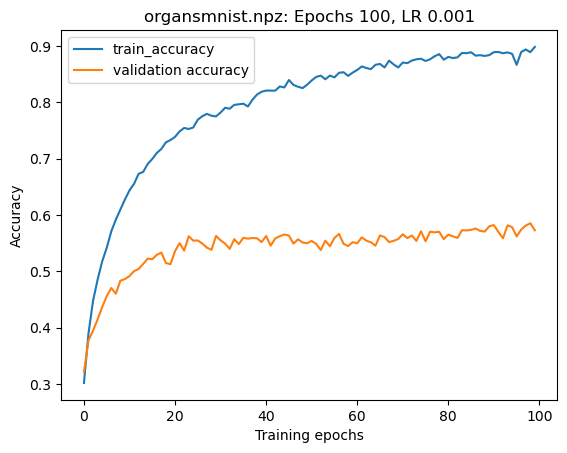

Training time: 34.86 seconds
Evaluation time: 0.22 seconds
Accuracy: 57.279, Loss: 5.49376, Epochs: 100, LR 0.001


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 26, 32)              │           2,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 13, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,123 (117.67 KB)

 Trainable params: 30,123 (117.67 KB)

 Non-trainable params: 0 (0.00 B)


Training... organsmnist.npz: Epochs 150, LR 0.001


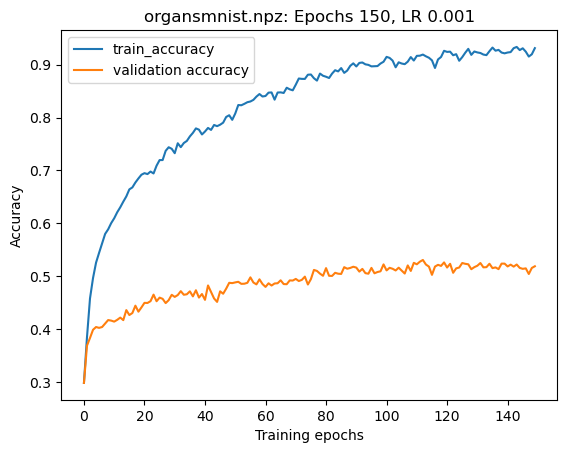

Training time: 51.48 seconds
Evaluation time: 0.2 seconds
Accuracy: 51.909, Loss: 12.68218, Epochs: 150, LR 0.001
DONE: 1925.818466424942 seconds


In [17]:
# NOTE: 'chestmnist.npz', # image, label size length mismatch, not used here
#files = ['bloodmnist.npz', 'breastmnist.npz', 'dermamnist.npz', 'octmnist.npz', 'organsmnist.npz', \
#         'nodulemnist3d.npz', 'organmnist3d.npz', 'retinamnist_128.npz']
#files = ['bloodmnist.npz', 'breastmnist.npz']
#files = ['breastmnist.npz']
files = ['breastmnist.npz', 'octmnist.npz', 'organsmnist.npz']

start_run = time.time()

rslt = {}
first_write = True

dtmin = get_time_with_minutes(get_localdate_str())
outfile = "CNN1d-" + dtmin +".csv"

for fn in files:
    csv_info = process_file(fn)

    # Append the new data to an existing CSV file
    df = pd.DataFrame(csv_info, columns=['fn','lr','epochs','accuracy','loss','train time'])
    if (first_write):
        # write to file (create or overwrite)
        df = pd.DataFrame(csv_info, columns=['fn','lr','epochs','accuracy','loss','train time'])
        df.to_csv(outfile, index=False)
        first_write = False
    else:
        # append to file
        df.to_csv(outfile, mode='a', index=False, header=False)

end_run = time.time() - start_run

print(f"DONE: {end_run} seconds")

In [18]:
def display_best(best_acc_indx, best_loss_indx):
    print(f"        best accuracy: Index {best_acc_indx}, least loss: Index {best_loss_indx}")

df = pd.read_csv(outfile)

lr = 'lr'
eps = 'epochs'
ac = 'accuracy'
ls = 'loss'
tt = 'train time'
filen = ""

best_acc = 0.0
best_loss = 100.0
best_acc_indx = 0
best_loss_indx = 0

print("CNN1D Comparison by Filename")
for index, row in df.iterrows():
    if not np.isnan(row['lr']):
        if (row['fn'] != filen):
            if (filen != ""):
                display_best(best_acc_indx, best_loss_indx)
            filen = row['fn']
            print(f"\n{row['fn']}")
            print(f"  index\t{lr}\t\t{eps}\t{ac}\t{ls}\t\t{tt}")
            
            best_acc = 0.0
            best_loss = 100.0
        else:
            tbs = '\t\t'
            if row[ls] >= 10.0:
                tbs = '\t'
            print(f"  {index}\t{row[lr]:.3f}\t\t{int(row[eps]):03}\t{row[ac]}\t\t{row[ls]:.5f}{tbs}{row[tt]} secs")
            if row[ac] > best_acc:
                best_acc = row[ac]
                best_acc_indx = index
            if row[ls] < best_loss:
                best_loss = row[ls]
                best_loss_indx = index
# for last file
display_best(best_acc_indx, best_loss_indx)

CNN1D Comparison by Filename

breastmnist.npz
  index	lr		epochs	accuracy	loss		train time
  2	0.100		050	73.08		2.77500		3.1 secs
  3	0.100		100	76.92		2.54366		5.79 secs
  4	0.100		150	78.21		1.64599		8.31 secs
  5	0.010		025	75.0		2.80250		1.81 secs
  6	0.010		050	81.41		1.26219		3.13 secs
  7	0.010		100	77.56		2.41877		5.72 secs
  8	0.010		150	80.77		1.46482		8.31 secs
  9	0.001		025	75.64		1.59492		1.83 secs
  10	0.001		050	76.92		2.33289		3.12 secs
  11	0.001		100	73.72		3.39159		5.69 secs
  12	0.001		150	77.56		1.98061		8.27 secs
        best accuracy: Index 6, least loss: Index 6

octmnist.npz
  index	lr		epochs	accuracy	loss		train time
  15	0.100		050	58.9		1.40129		77.23 secs
  16	0.100		100	55.6		1.52413		155.14 secs
  17	0.100		150	58.2		2.23883		231.46 secs
  18	0.010		025	59.2		1.10633		38.76 secs
  19	0.010		050	59.3		1.38585		77.13 secs
  20	0.010		100	57.3		2.15070		154.92 secs
  21	0.010		150	58.1		1.80982		233.99 secs
  22	0.001		025	51.5		1.45729		38.91 secs
  23	0